# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed",
    "device": "cuda",
    "lr": 0.0001,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": ["unit_power"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": ["unit_power"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run2_",
        },
    ],
    "dataset_seed": 500,
    "seed": 500,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'ORACLE.run1_32', 'ORACLE.run1_44', 'ORACLE.run1_20', 'ORACLE.run1_14', 'ORACLE.run1_50', 'ORACLE.run1_8', 'ORACLE.run1_38', 'ORACLE.run1_26'}


{'ORACLE.run2_14', 'ORACLE.run2_32', 'ORACLE.run2_20', 'ORACLE.run2_50', 'ORACLE.run2_38', 'ORACLE.run2_8', 'ORACLE.run2_26', 'ORACLE.run2_44'}


tensor([[[ 0.5241,  0.9130, -0.9299,  ..., -0.7101,  0.4903, -0.7777],
         [-0.4058,  0.3719,  0.1183,  ..., -0.4058, -1.0989, -0.8961]],

        [[ 0.1035,  1.1901, -0.4657,  ..., -0.9142,  0.3450, -0.9487],
         [-0.6554,  0.0862,  0.5692,  ..., -0.1035, -1.0349, -0.5865]],

        [[-0.9837,  0.4315,  1.3634,  ..., -0.4832,  0.1898,  1.2081],
         [-0.2934, -0.2416,  0.0345,  ...,  1.1218,  1.0010,  0.1726]],

        ...,

        [[-0.3340,  0.2733,  0.3644,  ..., -0.4251, -1.3816, -0.9869],
         [-0.2733, -1.0932,  0.5769,  ...,  0.9413, -0.5466,  0.3492]],

        [[ 0.5510, -0.4765, -0.5808,  ...,  0.2681,  1.2956,  0.6255],
         [ 0.8786,  0.8935, -1.0126,  ..., -0.7446,  0.4021, -0.9233]],

        [[ 0.4354, -0.7207, -0.5405,  ...,  0.8558,  1.0360,  0.3754],
         [ 1.0210,  0.7658, -1.1111,  ..., -0.4655,  0.4504, -1.1561]]])


In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 6720], examples_per_second: 32.5949, train_label_loss: 2.9158, 


epoch: 1, [batch: 672 / 6720], examples_per_second: 2292.1230, train_label_loss: 1.6906, 


epoch: 1, [batch: 1344 / 6720], examples_per_second: 2299.7397, train_label_loss: 0.7525, 


epoch: 1, [batch: 2016 / 6720], examples_per_second: 2297.9331, train_label_loss: 0.7658, 


epoch: 1, [batch: 2688 / 6720], examples_per_second: 2300.7117, train_label_loss: 0.5707, 


epoch: 1, [batch: 3360 / 6720], examples_per_second: 2513.1558, train_label_loss: 0.4608, 


epoch: 1, [batch: 4032 / 6720], examples_per_second: 2900.9188, train_label_loss: 0.6100, 


epoch: 1, [batch: 4704 / 6720], examples_per_second: 2887.8327, train_label_loss: 0.4145, 


epoch: 1, [batch: 5376 / 6720], examples_per_second: 2836.0339, train_label_loss: 0.6067, 


epoch: 1, [batch: 6048 / 6720], examples_per_second: 2566.7706, train_label_loss: 0.6282, 


epoch: 1, source_val_acc_label: 0.7371, target_val_acc_label: 0.7239, source_val_label_loss: 0.8605, target_val_label_loss: 0.8883, 


New best


epoch: 2, [batch: 1 / 6720], examples_per_second: 2.3989, train_label_loss: 0.8821, 


epoch: 2, [batch: 672 / 6720], examples_per_second: 2501.9717, train_label_loss: 0.7944, 


epoch: 2, [batch: 1344 / 6720], examples_per_second: 2315.7051, train_label_loss: 0.4800, 


epoch: 2, [batch: 2016 / 6720], examples_per_second: 2291.2188, train_label_loss: 0.5196, 


epoch: 2, [batch: 2688 / 6720], examples_per_second: 2314.2426, train_label_loss: 0.5800, 


epoch: 2, [batch: 3360 / 6720], examples_per_second: 2411.1922, train_label_loss: 0.2681, 


epoch: 2, [batch: 4032 / 6720], examples_per_second: 2618.3796, train_label_loss: 0.5249, 


epoch: 2, [batch: 4704 / 6720], examples_per_second: 2582.8688, train_label_loss: 0.4382, 


epoch: 2, [batch: 5376 / 6720], examples_per_second: 2481.2872, train_label_loss: 0.8692, 


epoch: 2, [batch: 6048 / 6720], examples_per_second: 2321.2966, train_label_loss: 0.1643, 


epoch: 2, source_val_acc_label: 0.8493, target_val_acc_label: 0.8358, source_val_label_loss: 0.4192, target_val_label_loss: 0.4825, 


New best


epoch: 3, [batch: 1 / 6720], examples_per_second: 2.0050, train_label_loss: 0.7303, 


epoch: 3, [batch: 672 / 6720], examples_per_second: 2287.3115, train_label_loss: 0.3095, 


epoch: 3, [batch: 1344 / 6720], examples_per_second: 2313.1368, train_label_loss: 0.1463, 


epoch: 3, [batch: 2016 / 6720], examples_per_second: 2332.4447, train_label_loss: 0.1486, 


epoch: 3, [batch: 2688 / 6720], examples_per_second: 2308.3319, train_label_loss: 0.5604, 


epoch: 3, [batch: 3360 / 6720], examples_per_second: 2493.1227, train_label_loss: 0.3632, 


epoch: 3, [batch: 4032 / 6720], examples_per_second: 2623.1906, train_label_loss: 0.3847, 


epoch: 3, [batch: 4704 / 6720], examples_per_second: 2651.1275, train_label_loss: 0.5121, 


epoch: 3, [batch: 5376 / 6720], examples_per_second: 2412.0165, train_label_loss: 0.4388, 


epoch: 3, [batch: 6048 / 6720], examples_per_second: 2609.5368, train_label_loss: 0.5540, 


epoch: 3, source_val_acc_label: 0.8705, target_val_acc_label: 0.8554, source_val_label_loss: 0.3597, target_val_label_loss: 0.4281, 


New best


epoch: 4, [batch: 1 / 6720], examples_per_second: 2.2757, train_label_loss: 0.3347, 


epoch: 4, [batch: 672 / 6720], examples_per_second: 2575.4512, train_label_loss: 0.2674, 


epoch: 4, [batch: 1344 / 6720], examples_per_second: 2682.0226, train_label_loss: 0.4443, 


epoch: 4, [batch: 2016 / 6720], examples_per_second: 2804.8250, train_label_loss: 0.2160, 


epoch: 4, [batch: 2688 / 6720], examples_per_second: 2872.4780, train_label_loss: 0.2914, 


epoch: 4, [batch: 3360 / 6720], examples_per_second: 2484.8780, train_label_loss: 0.5004, 


epoch: 4, [batch: 4032 / 6720], examples_per_second: 2604.3701, train_label_loss: 0.2522, 


epoch: 4, [batch: 4704 / 6720], examples_per_second: 2675.8269, train_label_loss: 0.7549, 


epoch: 4, [batch: 5376 / 6720], examples_per_second: 2355.9660, train_label_loss: 0.4467, 


epoch: 4, [batch: 6048 / 6720], examples_per_second: 2335.7983, train_label_loss: 0.2767, 


epoch: 4, source_val_acc_label: 0.8868, target_val_acc_label: 0.8648, source_val_label_loss: 0.3174, target_val_label_loss: 0.3927, 


New best


epoch: 5, [batch: 1 / 6720], examples_per_second: 2.0031, train_label_loss: 0.2611, 


epoch: 5, [batch: 672 / 6720], examples_per_second: 2312.7159, train_label_loss: 0.3036, 


epoch: 5, [batch: 1344 / 6720], examples_per_second: 2330.2864, train_label_loss: 0.3091, 


epoch: 5, [batch: 2016 / 6720], examples_per_second: 2344.6191, train_label_loss: 0.0568, 


epoch: 5, [batch: 2688 / 6720], examples_per_second: 2315.9383, train_label_loss: 0.3404, 


epoch: 5, [batch: 3360 / 6720], examples_per_second: 2476.1528, train_label_loss: 0.1583, 


epoch: 5, [batch: 4032 / 6720], examples_per_second: 2596.4689, train_label_loss: 0.1846, 


epoch: 5, [batch: 4704 / 6720], examples_per_second: 2704.9598, train_label_loss: 0.2212, 


epoch: 5, [batch: 5376 / 6720], examples_per_second: 2393.5482, train_label_loss: 0.1144, 


epoch: 5, [batch: 6048 / 6720], examples_per_second: 2332.5864, train_label_loss: 0.2895, 


epoch: 5, source_val_acc_label: 0.8902, target_val_acc_label: 0.8677, source_val_label_loss: 0.3055, target_val_label_loss: 0.3861, 


New best


epoch: 6, [batch: 1 / 6720], examples_per_second: 2.0247, train_label_loss: 0.4987, 


epoch: 6, [batch: 672 / 6720], examples_per_second: 2601.5140, train_label_loss: 0.3811, 


epoch: 6, [batch: 1344 / 6720], examples_per_second: 2632.5953, train_label_loss: 0.2110, 


epoch: 6, [batch: 2016 / 6720], examples_per_second: 2578.1023, train_label_loss: 0.2234, 


epoch: 6, [batch: 2688 / 6720], examples_per_second: 2526.0104, train_label_loss: 0.2814, 


epoch: 6, [batch: 3360 / 6720], examples_per_second: 2814.3329, train_label_loss: 0.2072, 


epoch: 6, [batch: 4032 / 6720], examples_per_second: 3012.6300, train_label_loss: 0.3780, 


epoch: 6, [batch: 4704 / 6720], examples_per_second: 3135.6449, train_label_loss: 0.3745, 


epoch: 6, [batch: 5376 / 6720], examples_per_second: 2996.5305, train_label_loss: 0.0484, 


epoch: 6, [batch: 6048 / 6720], examples_per_second: 2343.2759, train_label_loss: 0.6538, 


epoch: 6, source_val_acc_label: 0.8889, target_val_acc_label: 0.8656, source_val_label_loss: 0.3091, target_val_label_loss: 0.3888, 


epoch: 7, [batch: 1 / 6720], examples_per_second: 2.0121, train_label_loss: 0.3358, 


epoch: 7, [batch: 672 / 6720], examples_per_second: 2305.6074, train_label_loss: 0.3341, 


epoch: 7, [batch: 1344 / 6720], examples_per_second: 2323.2137, train_label_loss: 0.4012, 


epoch: 7, [batch: 2016 / 6720], examples_per_second: 2313.0607, train_label_loss: 0.2015, 


epoch: 7, [batch: 2688 / 6720], examples_per_second: 2323.5649, train_label_loss: 0.2513, 


epoch: 7, [batch: 3360 / 6720], examples_per_second: 2563.5357, train_label_loss: 0.1640, 


epoch: 7, [batch: 4032 / 6720], examples_per_second: 2612.3826, train_label_loss: 0.3126, 


epoch: 7, [batch: 4704 / 6720], examples_per_second: 2576.9589, train_label_loss: 0.1593, 


epoch: 7, [batch: 5376 / 6720], examples_per_second: 2315.3343, train_label_loss: 0.1819, 


epoch: 7, [batch: 6048 / 6720], examples_per_second: 2314.4422, train_label_loss: 0.1576, 


epoch: 7, source_val_acc_label: 0.8978, target_val_acc_label: 0.8742, source_val_label_loss: 0.2881, target_val_label_loss: 0.3744, 


New best


epoch: 8, [batch: 1 / 6720], examples_per_second: 2.0262, train_label_loss: 0.3155, 


epoch: 8, [batch: 672 / 6720], examples_per_second: 2306.0118, train_label_loss: 0.3783, 


epoch: 8, [batch: 1344 / 6720], examples_per_second: 2323.7415, train_label_loss: 0.0596, 


epoch: 8, [batch: 2016 / 6720], examples_per_second: 2381.9410, train_label_loss: 0.3147, 


epoch: 8, [batch: 2688 / 6720], examples_per_second: 2597.6309, train_label_loss: 0.1448, 


epoch: 8, [batch: 3360 / 6720], examples_per_second: 2907.9778, train_label_loss: 0.1888, 


epoch: 8, [batch: 4032 / 6720], examples_per_second: 2946.1972, train_label_loss: 0.5211, 


epoch: 8, [batch: 4704 / 6720], examples_per_second: 2854.7826, train_label_loss: 0.1383, 


epoch: 8, [batch: 5376 / 6720], examples_per_second: 2570.7628, train_label_loss: 0.2663, 


epoch: 8, [batch: 6048 / 6720], examples_per_second: 2633.3427, train_label_loss: 0.1763, 


epoch: 8, source_val_acc_label: 0.9070, target_val_acc_label: 0.8795, source_val_label_loss: 0.2611, target_val_label_loss: 0.3640, 


New best


epoch: 9, [batch: 1 / 6720], examples_per_second: 2.4164, train_label_loss: 0.0395, 


epoch: 9, [batch: 672 / 6720], examples_per_second: 2292.2696, train_label_loss: 0.1648, 


epoch: 9, [batch: 1344 / 6720], examples_per_second: 2307.7438, train_label_loss: 0.1868, 


epoch: 9, [batch: 2016 / 6720], examples_per_second: 2314.9115, train_label_loss: 0.5120, 


epoch: 9, [batch: 2688 / 6720], examples_per_second: 2340.3028, train_label_loss: 0.1380, 


epoch: 9, [batch: 3360 / 6720], examples_per_second: 2572.2520, train_label_loss: 0.2376, 


epoch: 9, [batch: 4032 / 6720], examples_per_second: 2604.3052, train_label_loss: 0.1000, 


epoch: 9, [batch: 4704 / 6720], examples_per_second: 2536.1634, train_label_loss: 0.0660, 


epoch: 9, [batch: 5376 / 6720], examples_per_second: 2319.4693, train_label_loss: 0.0671, 


epoch: 9, [batch: 6048 / 6720], examples_per_second: 2318.4419, train_label_loss: 0.2356, 


epoch: 9, source_val_acc_label: 0.9065, target_val_acc_label: 0.8793, source_val_label_loss: 0.2677, target_val_label_loss: 0.3590, 


epoch: 10, [batch: 1 / 6720], examples_per_second: 2.0009, train_label_loss: 0.0660, 


epoch: 10, [batch: 672 / 6720], examples_per_second: 2296.1484, train_label_loss: 0.0565, 


epoch: 10, [batch: 1344 / 6720], examples_per_second: 2315.9231, train_label_loss: 0.1466, 


epoch: 10, [batch: 2016 / 6720], examples_per_second: 2335.9448, train_label_loss: 0.0963, 


epoch: 10, [batch: 2688 / 6720], examples_per_second: 2373.8924, train_label_loss: 0.2373, 


epoch: 10, [batch: 3360 / 6720], examples_per_second: 2609.0287, train_label_loss: 0.1487, 


epoch: 10, [batch: 4032 / 6720], examples_per_second: 2602.5781, train_label_loss: 0.4253, 


epoch: 10, [batch: 4704 / 6720], examples_per_second: 2507.2406, train_label_loss: 0.0580, 


epoch: 10, [batch: 5376 / 6720], examples_per_second: 2483.2643, train_label_loss: 0.0157, 


epoch: 10, [batch: 6048 / 6720], examples_per_second: 2595.1239, train_label_loss: 0.5134, 


epoch: 10, source_val_acc_label: 0.8974, target_val_acc_label: 0.8655, source_val_label_loss: 0.2951, target_val_label_loss: 0.4006, 


epoch: 11, [batch: 1 / 6720], examples_per_second: 2.2568, train_label_loss: 0.1074, 


epoch: 11, [batch: 672 / 6720], examples_per_second: 2673.8373, train_label_loss: 0.2074, 


epoch: 11, [batch: 1344 / 6720], examples_per_second: 2756.9771, train_label_loss: 0.4179, 


epoch: 11, [batch: 2016 / 6720], examples_per_second: 2967.1735, train_label_loss: 0.0666, 


epoch: 11, [batch: 2688 / 6720], examples_per_second: 2377.0407, train_label_loss: 0.2390, 


epoch: 11, [batch: 3360 / 6720], examples_per_second: 2592.8037, train_label_loss: 0.0817, 


epoch: 11, [batch: 4032 / 6720], examples_per_second: 2606.5909, train_label_loss: 0.1870, 


epoch: 11, [batch: 4704 / 6720], examples_per_second: 2451.1851, train_label_loss: 0.0269, 


epoch: 11, [batch: 5376 / 6720], examples_per_second: 2299.0583, train_label_loss: 0.1661, 


epoch: 11, [batch: 6048 / 6720], examples_per_second: 2293.3615, train_label_loss: 0.0678, 


epoch: 11, source_val_acc_label: 0.9016, target_val_acc_label: 0.8737, source_val_label_loss: 0.2856, target_val_label_loss: 0.3963, 


epoch: 12, [batch: 1 / 6720], examples_per_second: 2.0099, train_label_loss: 0.2891, 


epoch: 12, [batch: 672 / 6720], examples_per_second: 2303.1583, train_label_loss: 0.1918, 


epoch: 12, [batch: 1344 / 6720], examples_per_second: 2300.3060, train_label_loss: 0.0704, 


epoch: 12, [batch: 2016 / 6720], examples_per_second: 2305.9555, train_label_loss: 0.3033, 


epoch: 12, [batch: 2688 / 6720], examples_per_second: 2449.0532, train_label_loss: 0.2712, 


epoch: 12, [batch: 3360 / 6720], examples_per_second: 2636.2515, train_label_loss: 0.0602, 


epoch: 12, [batch: 4032 / 6720], examples_per_second: 2664.1809, train_label_loss: 0.4320, 


epoch: 12, [batch: 4704 / 6720], examples_per_second: 2350.7352, train_label_loss: 0.2867, 


epoch: 12, [batch: 5376 / 6720], examples_per_second: 2302.4576, train_label_loss: 0.1663, 


epoch: 12, [batch: 6048 / 6720], examples_per_second: 2312.2630, train_label_loss: 0.1742, 


epoch: 12, source_val_acc_label: 0.9098, target_val_acc_label: 0.8810, source_val_label_loss: 0.2590, target_val_label_loss: 0.3740, 


New best


epoch: 13, [batch: 1 / 6720], examples_per_second: 2.1570, train_label_loss: 0.3249, 


epoch: 13, [batch: 672 / 6720], examples_per_second: 2562.5124, train_label_loss: 0.0083, 


epoch: 13, [batch: 1344 / 6720], examples_per_second: 2605.5559, train_label_loss: 0.3094, 


epoch: 13, [batch: 2016 / 6720], examples_per_second: 2624.1456, train_label_loss: 0.1679, 


epoch: 13, [batch: 2688 / 6720], examples_per_second: 2892.2752, train_label_loss: 0.0620, 


epoch: 13, [batch: 3360 / 6720], examples_per_second: 2950.0040, train_label_loss: 0.0539, 


epoch: 13, [batch: 4032 / 6720], examples_per_second: 3582.3116, train_label_loss: 0.1032, 


epoch: 13, [batch: 4704 / 6720], examples_per_second: 2725.6897, train_label_loss: 0.2866, 


epoch: 13, [batch: 5376 / 6720], examples_per_second: 2306.3022, train_label_loss: 0.1200, 


epoch: 13, [batch: 6048 / 6720], examples_per_second: 2289.4897, train_label_loss: 0.1465, 


epoch: 13, source_val_acc_label: 0.9000, target_val_acc_label: 0.8671, source_val_label_loss: 0.2863, target_val_label_loss: 0.4077, 


epoch: 14, [batch: 1 / 6720], examples_per_second: 2.0231, train_label_loss: 0.1938, 


epoch: 14, [batch: 672 / 6720], examples_per_second: 2279.7749, train_label_loss: 0.0344, 


epoch: 14, [batch: 1344 / 6720], examples_per_second: 2331.7832, train_label_loss: 0.0989, 


epoch: 14, [batch: 2016 / 6720], examples_per_second: 2327.4096, train_label_loss: 0.1643, 


epoch: 14, [batch: 2688 / 6720], examples_per_second: 2496.4452, train_label_loss: 0.0201, 


epoch: 14, [batch: 3360 / 6720], examples_per_second: 2624.2380, train_label_loss: 0.2486, 


epoch: 14, [batch: 4032 / 6720], examples_per_second: 2685.9576, train_label_loss: 0.0741, 


epoch: 14, [batch: 4704 / 6720], examples_per_second: 2300.9140, train_label_loss: 0.0394, 


epoch: 14, [batch: 5376 / 6720], examples_per_second: 2296.6196, train_label_loss: 0.0335, 


epoch: 14, [batch: 6048 / 6720], examples_per_second: 2296.1709, train_label_loss: 0.0354, 


epoch: 14, source_val_acc_label: 0.9092, target_val_acc_label: 0.8760, source_val_label_loss: 0.2668, target_val_label_loss: 0.3960, 


epoch: 15, [batch: 1 / 6720], examples_per_second: 1.9958, train_label_loss: 0.1889, 


epoch: 15, [batch: 672 / 6720], examples_per_second: 2319.2660, train_label_loss: 0.1395, 


epoch: 15, [batch: 1344 / 6720], examples_per_second: 2381.8771, train_label_loss: 0.3248, 


epoch: 15, [batch: 2016 / 6720], examples_per_second: 2595.5044, train_label_loss: 0.0111, 


epoch: 15, [batch: 2688 / 6720], examples_per_second: 2887.3156, train_label_loss: 0.1964, 


epoch: 15, [batch: 3360 / 6720], examples_per_second: 2958.5121, train_label_loss: 0.1163, 


epoch: 15, [batch: 4032 / 6720], examples_per_second: 3011.3539, train_label_loss: 0.1835, 


epoch: 15, [batch: 4704 / 6720], examples_per_second: 2548.8276, train_label_loss: 0.2873, 


epoch: 15, [batch: 5376 / 6720], examples_per_second: 2605.8505, train_label_loss: 0.0887, 


epoch: 15, [batch: 6048 / 6720], examples_per_second: 2621.8637, train_label_loss: 0.0231, 


epoch: 15, source_val_acc_label: 0.9105, target_val_acc_label: 0.8765, source_val_label_loss: 0.2588, target_val_label_loss: 0.3941, 


epoch: 16, [batch: 1 / 6720], examples_per_second: 2.2388, train_label_loss: 0.0892, 


epoch: 16, [batch: 672 / 6720], examples_per_second: 2298.6495, train_label_loss: 0.3417, 


epoch: 16, [batch: 1344 / 6720], examples_per_second: 2313.8891, train_label_loss: 0.1821, 


epoch: 16, [batch: 2016 / 6720], examples_per_second: 2328.8920, train_label_loss: 0.1819, 


epoch: 16, [batch: 2688 / 6720], examples_per_second: 2520.5652, train_label_loss: 0.0582, 


epoch: 16, [batch: 3360 / 6720], examples_per_second: 2592.2813, train_label_loss: 0.0331, 


epoch: 16, [batch: 4032 / 6720], examples_per_second: 2583.4591, train_label_loss: 0.1551, 


epoch: 16, [batch: 4704 / 6720], examples_per_second: 2329.9335, train_label_loss: 0.0062, 


epoch: 16, [batch: 5376 / 6720], examples_per_second: 2313.6413, train_label_loss: 0.1479, 


epoch: 16, [batch: 6048 / 6720], examples_per_second: 2294.9214, train_label_loss: 0.1789, 


epoch: 16, source_val_acc_label: 0.9124, target_val_acc_label: 0.8770, source_val_label_loss: 0.2606, target_val_label_loss: 0.4052, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

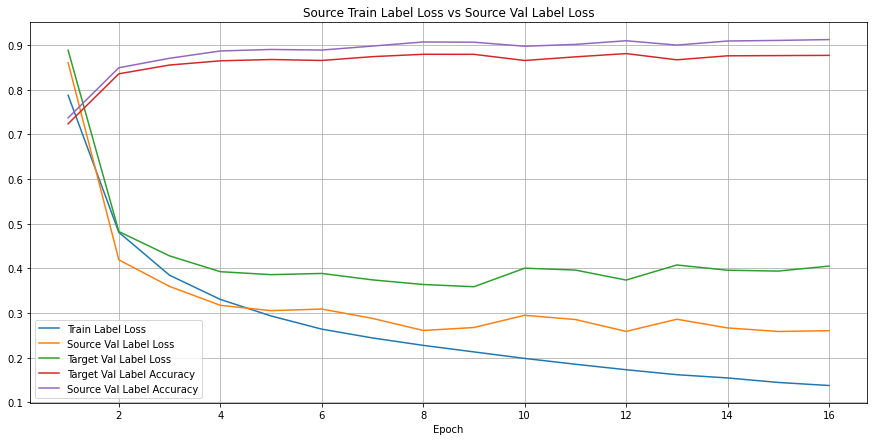

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

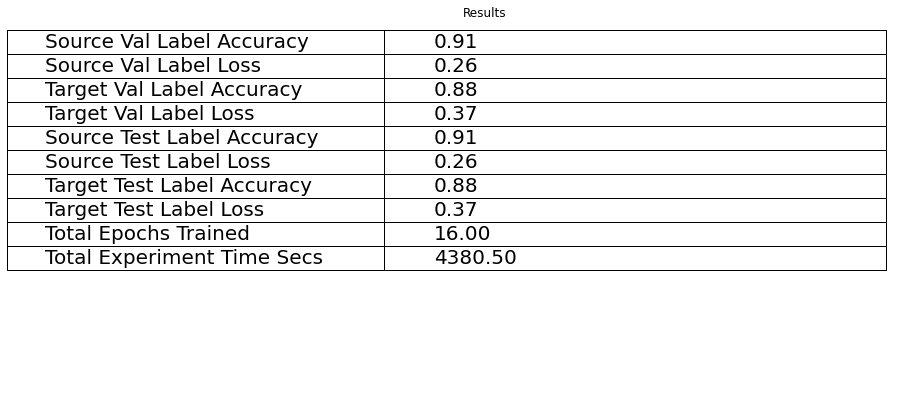

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

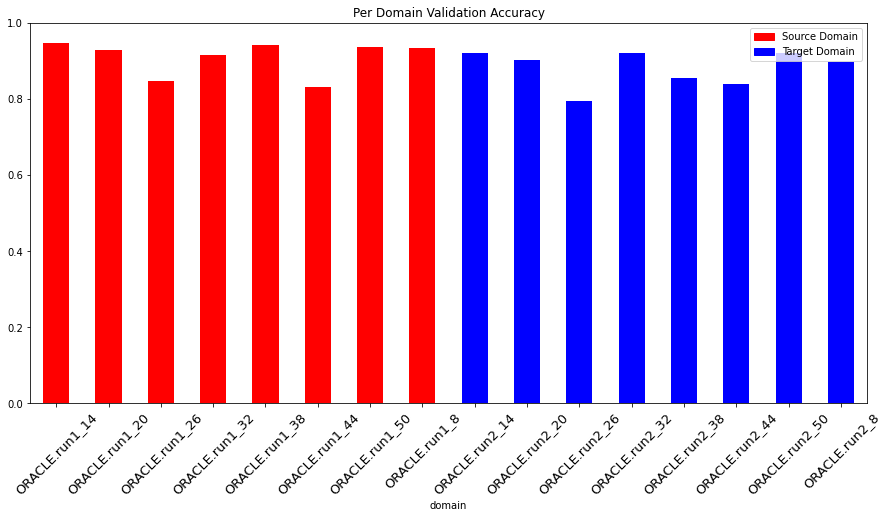

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.91005859375 Target Test Label Accuracy: 0.8782877604166667
Source Val Label Accuracy: 0.909765625 Target Val Label Accuracy: 0.8809895833333333


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed", "parameters": {"experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed", "device": "cuda", "lr": 0.0001, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 2048